In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# pip install seaborn

# !pip install tensorflow


In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [12]:
# df = pd.read_csv('/content/drive/MyDrive/BTC_Prediction_Training/data/btc.csv')
# df.head()

In [13]:
# df.columns

In [14]:
# df.dtypes

### 1. Preprocessing (same as you already have)

In [15]:
def load_and_preprocess(csv_path, seq_length=24, test_ratio=0.2):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler

    df = pd.read_csv(csv_path, parse_dates=['Datetime'])

    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    df = df[features].astype(float)

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    # Create sequences
    X, y = [], []
    for i in range(seq_length, len(scaled)):
        X.append(scaled[i - seq_length:i])
        y.append(scaled[i, 3])  # Close price

    X, y = np.array(X), np.array(y)

    # Train-test split
    split_index = int(len(X) * (1 - test_ratio))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, y_train, X_test, y_test, scaler


### 2. LSTM Model in TensorFlow

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


csv_path = "/content/drive/MyDrive/BTC_Prediction_Training/data/btc.csv"

# Load preprocessed data
X_train, y_train, X_test, y_test, scaler = load_and_preprocess(csv_path)

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)


Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0409 - val_loss: 6.9176e-04
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9887e-04 - val_loss: 3.1754e-04
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8175e-04 - val_loss: 2.8688e-04
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6449e-04 - val_loss: 2.8487e-04
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9390e-04 - val_loss: 3.0539e-04
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4663e-04 - val_loss: 2.7415e-04
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.7813e-04 - val_loss: 2.4163e-04
Epoch 8/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0901e-04 - val_loss: 2.4305e-04
Epoch 9/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9151e-04 - val_loss: 2.7639e-04
Epoch 10/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1963e-04 - val_loss: 2.1169e-04
Epoch 11/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3547e-04 - val_loss: 

### 3. Evaluate & Predict

In [17]:
loss = model.evaluate(X_test, y_test)
print("Test MSE:", loss)

# Predict
y_pred = model.predict(X_test)

# Optionally inverse scale
import numpy as np
scaled_close = np.zeros((len(y_pred), 5))  # 5 = total feature count
scaled_close[:, 3] = y_pred.flatten()      # index 3 = 'Close'

y_pred_actual = scaler.inverse_transform(scaled_close)[:, 3]  # back to original scale


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5986e-04 
Test MSE: 0.0007311488152481616
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


### 4. Plot Predictions vs Actual

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


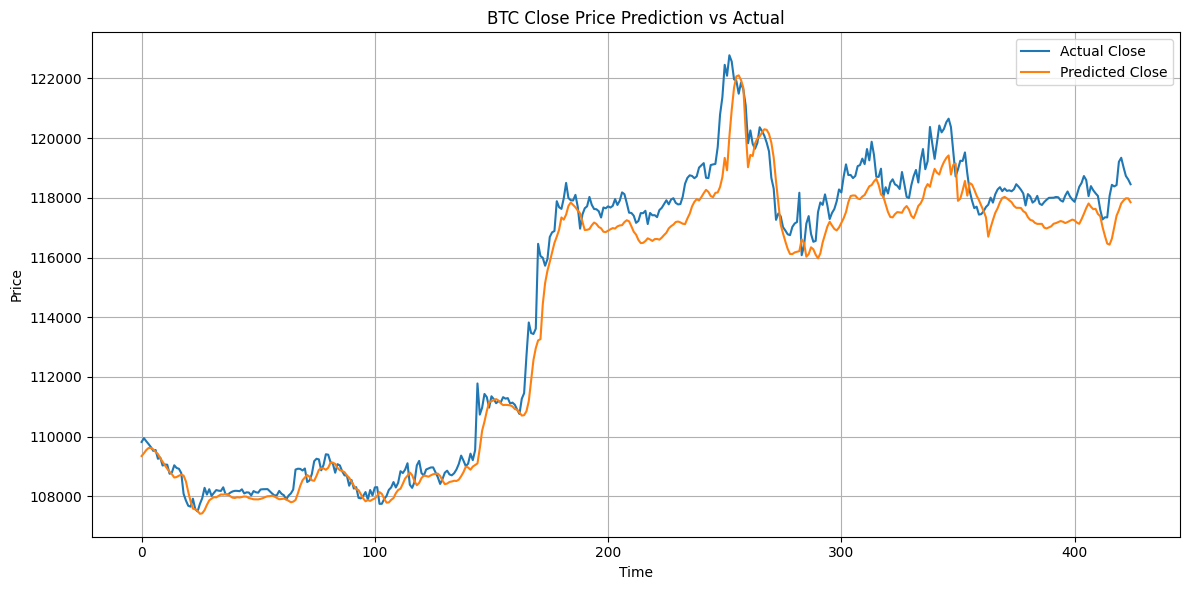

In [18]:
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test)

# Inverse scale
import numpy as np
scaled_pred = np.zeros((len(y_pred), 5))
scaled_pred[:, 3] = y_pred.flatten()
predicted_close = scaler.inverse_transform(scaled_pred)[:, 3]

scaled_actual = np.zeros((len(y_test), 5))
scaled_actual[:, 3] = y_test.flatten()
actual_close = scaler.inverse_transform(scaled_actual)[:, 3]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_close, label='Actual Close')
plt.plot(predicted_close, label='Predicted Close')
plt.title("BTC Close Price Prediction vs Actual")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 5. Save the Model

###### If you want to retrain or reuse it later:

In [19]:
model.save("/content/drive/MyDrive/BTC_Prediction_Training/Trained_Model/crypto_lstm_model.h5")

#### 6. Predict Future Close (1-step ahead)

In [20]:
latest_sequence = X_test[-1:]  # shape: (1, seq_len, 5)
next_pred_scaled = model.predict(latest_sequence)

# Inverse scale
temp = np.zeros((1, 5))
temp[0, 3] = next_pred_scaled
next_close = scaler.inverse_transform(temp)[0, 3]

print(f"Predicted next hour close price: ${next_close:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted next hour close price: $117850.70


#### ✅ 3. Use with the flexible input prediction function
Here's the complete function that:

Loads from a CSV

Uses the last N timesteps before a user-specified datetime

Predicts the next hour’s Close price

In [2]:
def predict_n_hours_ahead_from_csv(model, csv_path, input_datetime_str, seq_len=12):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler

    # Ask user how far into the future to predict
    future_str = input("How far ahead to predict? (e.g., '3d' for 3 days, '12h' for 12 hours): ").strip().lower()
    if future_str.endswith('d'):
        hours_ahead = int(future_str[:-1]) * 24
    elif future_str.endswith('h'):
        hours_ahead = int(future_str[:-1])
    else:
        raise ValueError("Invalid input format. Use 'Nd' for days or 'Nh' for hours.")

    # Load and prepare data
    df = pd.read_csv(csv_path, parse_dates=["Datetime"])
    df = df.sort_values("Datetime")

    # Localize user input to UTC
    input_datetime = pd.to_datetime(input_datetime_str).tz_localize("UTC")

    # Get last `seq_len` rows before given timestamp
    prev_data = df[df["Datetime"] < input_datetime].tail(seq_len)
    if len(prev_data) < seq_len:
        raise ValueError(f"Need at least {seq_len} rows before {input_datetime}, only found {len(prev_data)}")

    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    scaler = MinMaxScaler()
    scaled_seq = scaler.fit_transform(prev_data[features])

    preds = []
    timestamps = []

    for i in range(hours_ahead):
        # Prepare input shape for LSTM
        X_input = np.expand_dims(scaled_seq, axis=0)
        pred_scaled = model.predict(X_input, verbose=0)

        # Inverse scale: we only have predicted Close, so we place it in the 3rd column
        dummy = np.zeros((1, 5))
        dummy[0, 3] = pred_scaled
        predicted_row = scaler.inverse_transform(dummy)[0]

        preds.append(predicted_row[3])

        # Update timestamps
        last_time = input_datetime if i == 0 else timestamps[-1]
        timestamps.append(last_time + pd.Timedelta(hours=1))

        # ⚠️ Update only Close; others copied from last known row (not ideal but acceptable if model is Close-only)
        last_known_scaled = scaled_seq[-1].copy()
        last_known_scaled[3] = pred_scaled  # Update just the Close value

        scaled_seq = np.vstack([scaled_seq[1:], last_known_scaled])

    # Output predictions
    for t, p in zip(timestamps, preds):
        print(f"📈 Predicted Close at {t} is ${p:.2f}")


In [3]:
# model = load_model(model_path, compile=False)
# predict_n_hours_ahead_from_csv(model, csv_path, "2025-07-21 20:00")


from tensorflow.keras.models import load_model  # ← Add this

model_path = "/content/drive/MyDrive/BTC_Prediction_Training/Trained_Model/crypto_lstm_model.h5"
csv_path = "/content/drive/MyDrive/BTC_Prediction_Training/data/btc.csv"

model = load_model(model_path, compile=False)
predict_n_hours_ahead_from_csv(model, csv_path, "2025-07-23 11:00")

How far ahead to predict? (e.g., '3d' for 3 days, '12h' for 12 hours): 5d


/tmp/ipython-input-2-3252692023.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy[0, 3] = pred_scaled
/tmp/ipython-input-2-3252692023.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_scaled[3] = pred_scaled  # Update just the Close value
/tmp/ipython-input-2-3252692023.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy[0, 3] = pred_scaled
/tmp/ipython-input-2-3252692023.py:52: DeprecationWarning: Conversion of an array with ndim > 0 

📈 Predicted Close at 2025-07-23 12:00:00+00:00 is $118751.04
📈 Predicted Close at 2025-07-23 13:00:00+00:00 is $118689.40
📈 Predicted Close at 2025-07-23 14:00:00+00:00 is $118655.99
📈 Predicted Close at 2025-07-23 15:00:00+00:00 is $118649.97
📈 Predicted Close at 2025-07-23 16:00:00+00:00 is $118660.60
📈 Predicted Close at 2025-07-23 17:00:00+00:00 is $118682.24
📈 Predicted Close at 2025-07-23 18:00:00+00:00 is $118706.21
📈 Predicted Close at 2025-07-23 19:00:00+00:00 is $118731.52
📈 Predicted Close at 2025-07-23 20:00:00+00:00 is $118745.21
📈 Predicted Close at 2025-07-23 21:00:00+00:00 is $118757.60
📈 Predicted Close at 2025-07-23 22:00:00+00:00 is $118768.17
📈 Predicted Close at 2025-07-23 23:00:00+00:00 is $118773.20
📈 Predicted Close at 2025-07-24 00:00:00+00:00 is $118773.81
📈 Predicted Close at 2025-07-24 01:00:00+00:00 is $118775.11
📈 Predicted Close at 2025-07-24 02:00:00+00:00 is $118775.14
📈 Predicted Close at 2025-07-24 03:00:00+00:00 is $118774.37
📈 Predicted Close at 202

/tmp/ipython-input-2-3252692023.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy[0, 3] = pred_scaled
/tmp/ipython-input-2-3252692023.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known_scaled[3] = pred_scaled  # Update just the Close value
/tmp/ipython-input-2-3252692023.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dummy[0, 3] = pred_scaled
/tmp/ipython-input-2-3252692023.py:52: DeprecationWarning: Conversion of an array with ndim > 0 